# 6 Hour Forecast using Dynamic Graph

In [1]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp
import networkx
import torch_geometric
import torch
from torch_geometric.utils.convert import from_networkx
from scipy.sparse import coo_matrix

# for tweaked_TAGConv
import torch.nn as nn
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm # adjacency matrix normalization
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros # initialize weights and biases for nn
from torch_geometric.typing import Adj, OptTensor, SparseTensor
from torch_geometric.utils import spmm # for sparse matrix multiplication

In [2]:
from utils import blocked_cross_validation_idx,get_windows_idx,get_train_batch_blocks

## Initialize
1. Aggregated (dataframe available at https://drive.google.com/drive/folders/1CwSLAJeCGUuHXRJOZ9YgkraHYaE8pGGH?usp=sharing)
2. Load aggregated
3. Load window csv with lclids corresponding to aggregated data

In [3]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    print("Pytorch is built with MPS on this device:", torch.backends.mps.is_built())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device("mps")
print(device)

mps


In [5]:
# load the data
file = open('uk-smart-meter-aggregated/df_agg.pkl','rb')
df_agg = pickle.load(file)
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2012-01-01 00:00:00 to 2013-12-31 23:00:00
Columns: 5558 entries, 2 to 5564
dtypes: float64(5558)
memory usage: 744.1 MB


In [6]:
file = open('uk-smart-meter-aggregated/windows_agg_ids.pkl','rb')
windows = pickle.load(file)
windows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558 entries, 0 to 5557
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   LCLid        5558 non-null   int64          
 1   Enabled At   5558 non-null   datetime64[ns] 
 2   Disabled At  5558 non-null   datetime64[ns] 
 3   Duration     5558 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 217.1 KB


## Snapshot-based temporal graph
Idea: Build the adjacency matrix for all nodes using `create_adjacency_matrix`. Select a time-stamp for example [0]: '2012-01-01 00:00:00' or [1]: '2012-01-01 01:00:00' and so on. For this time-stamp what all nodes are active? Make an adjacency matrix for only these nodes for that particular time stamp using `get_snapshot_adjacency`. This function further returns the LCLids of active nodes (2,3,... 5564) and the indices of those active nodes (dataframe indices as in from range 0 to 5557).

1. Get the adjacency matrix for *all the nodes* at once to avoid computation

Number of unique start dates:  2154
Graph connected for k=50: True
sparsity:  0.9439180477754235


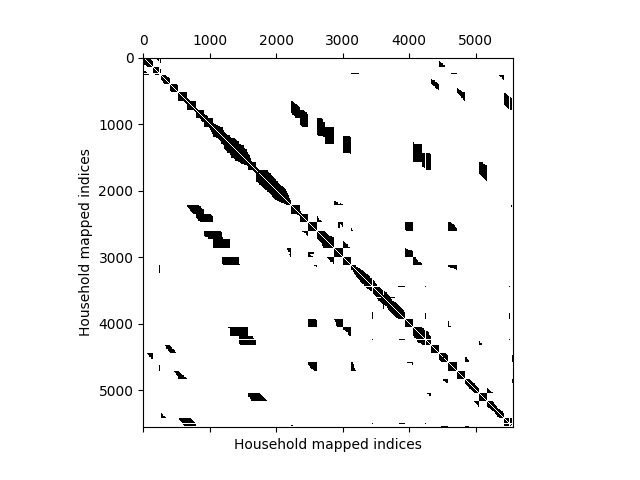

In [7]:
def create_adjacency_matrix(lclids, k):
    number_of_nodes = sum([len(l) for l in lclids])
    adjacency_matrix = np.zeros((number_of_nodes, number_of_nodes))
    # Create the graph by iterating over the list of lists of LCLids
    # and connecting all nodes in the list with each other
    # and with the k-nearest lists
    for i in range(len(lclids)): # range 2156
        for j in range(len(lclids)): # range 2156
            if i == j:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
            elif abs(i-j) <= k:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
    adjacency_matrix = adjacency_matrix - np.eye(number_of_nodes)
    return sp.sparse.bsr_array(adjacency_matrix)

# Sort rows by start date
windows_copy = windows.sort_values(by='Enabled At').copy()

# Get an ordered list of dates 'Enabled At'
enable_unique_dates = windows_copy['Enabled At'].unique()

# Get a list of lists of LCLids that have the same start date
nbor_lclids = [windows_copy[windows_copy['Enabled At'] == date].index.tolist() for date in enable_unique_dates]
print('Number of unique start dates: ', len(enable_unique_dates))
assert len(windows) == sum([len(l) for l in nbor_lclids])

# K-nearest neighbours
k = 50

adjacency_matrix = create_adjacency_matrix(nbor_lclids, k)
# Compute the sparsity of the adjacency matrix
sparsity = 1 - sp.sparse.bsr_matrix.count_nonzero(adjacency_matrix) / np.prod(adjacency_matrix.shape)
G = networkx.from_scipy_sparse_array(adjacency_matrix)
print(f'Graph connected for k={k}: {networkx.is_connected(G)}')
print('sparsity: ', sparsity)

plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
plt.xlabel("Household mapped indices"), plt.ylabel("Household mapped indices")
# save the adjacency matrix
np.save('Results/adjacency_matrix.npy', adjacency_matrix)
plt.show()

### Align snapshots

Idea: Take snapshots for a window and extract the sub-adjacency matrices (only considering active nodes) and node features. And stack these sub-adjacency matrices as a dictionary (book).

Align the snapshots of different adjacency matrices to become size compatible. For example snapshot 1 has $R^{410\times410}$, snapshot 2 has $R^{450\times 450}$. This means that first snapshot has 410 active nodes and second snapshot has 450 active nodes. So, make a union set of all these nodes and "align" the shape of snapshot 2 adjacency matrix, node-features and edge_index to the shape of snapshot 2. So, snapshot 1 will also have adjacency matrix of size $R^{450\times 450}$ but with zeros at entries corresponding to the node that is not active in that snapshot 1.

In [26]:
df = pd.DataFrame({
    'DateTime': pd.date_range(start='2012-01-01 00:00:00', end='2013-12-31 23:00:00', freq='1h')
})
df.head()


,DateTime
0,2012-01-01 00:00:00
1,2012-01-01 01:00:00
2,2012-01-01 02:00:00
3,2012-01-01 03:00:00
4,2012-01-01 04:00:00


In [ ]:
train_months=21
test_months=3
batch_size=128
overlap_months=0
train_test_blocks = blocked_cross_validation_idx(df,train_months,test_months,overlap_months)[0]
batch_windows = get_train_batch_blocks(train_test_blocks[0],train_test_blocks[1],batch_size=batch_size)

In [17]:
train_test_blocks

(0, 15335, 15336, 17543)

In [16]:
batch_windows[0], batch_windows[1]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 1

In [24]:
def impute_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Fill missing values in the dataframe with the last known value of the timeseries. If the previous value is missing, fill with the next known value.

        Args:
        df (pd.DataFrame): 1D timeseries given as a pandas dataframe with the values in the field specified by value_axis.
    """
    # Find last value that is not NaN or zero before a value that is NaN or zero
    df.replace(0, np.nan, inplace=True)
    df.ffill(inplace=True, axis=0)
    df.bfill(inplace=True, axis=0)
    return df

In [25]:
df_agg = impute_missing_values(df_agg)
df_agg.head()

,2,3,4,6,7,8,9,10,11,12,...,5535,5536,5537,5538,5541,5549,5550,5551,5557,5564
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0.143,1.81,0.182,0.096,0.349,1.118,0.287,0.918,0.626,0.337,...,0.031,0.012,0.658,0.089,0.481,0.575,0.568,0.234,0.18,0.683
2012-01-01 01:00:00,0.143,1.81,0.182,0.096,0.349,1.118,0.287,0.918,0.626,0.337,...,0.031,0.012,0.658,0.089,0.481,0.575,0.568,0.234,0.18,0.683
2012-01-01 02:00:00,0.143,1.81,0.182,0.096,0.349,1.118,0.287,0.918,0.626,0.337,...,0.031,0.012,0.658,0.089,0.481,0.575,0.568,0.234,0.18,0.683
2012-01-01 03:00:00,0.143,1.81,0.182,0.096,0.349,1.118,0.287,0.918,0.626,0.337,...,0.031,0.012,0.658,0.089,0.481,0.575,0.568,0.234,0.18,0.683
2012-01-01 04:00:00,0.143,1.81,0.182,0.096,0.349,1.118,0.287,0.918,0.626,0.337,...,0.031,0.012,0.658,0.089,0.481,0.575,0.568,0.234,0.18,0.683


### Graph-VAR

$$
\mathbf{x_t} = \sum_{p=1}^{P} \sum_{k=0}^{K} h_{kp}\mathbf{S}^k \mathbf{x}_{t-p} 
$$

where P in our case will be 24. 

Dataset has 

In [32]:
df_agg.shape

(17544, 5558)

In [36]:
type(adjacency_matrix)

scipy.sparse._bsr.bsr_array

In [62]:
import scipy.sparse
from torch_geometric.utils import from_scipy_sparse_matrix

class TemporalGraphDataset:
    def __init__(self, df, edge_index, num_nodes):
        """
        Initializes an empty dictionary to store graph data for different time instances.
        """
        self.df = df
        # Normalize edge index and compute edge weights
        # Convert edge_index to COO format
        edge_index, edge_weight = from_scipy_sparse_matrix(edge_index)
        edge_index, edge_weight = gcn_norm(edge_index=edge_index,
                                           num_nodes=num_nodes,
                                           edge_weight=edge_weight,
                                           add_self_loops=False)
        self.edge_index = edge_index
        self.edge_weight = edge_weight


    def get_feature_target(self, start_batch_idx, end_batch_idx, target_idx, P):
        """
        Returns the feature and target data for a given time index `target_idx` in the batch
        specified by start_batch_idx and end_batch_idx.
        """
        if target_idx - P < 0:
            raise ValueError(f"Target index ({target_idx}) needs to be larger than P ({P}) in every batch")
        start = max(start_batch_idx + target_idx - P, start_batch_idx)
        if start > end_batch_idx:
            raise ValueError(f"Target index ({target_idx}) needs to be smaller than end_batch_idx ({end_batch_idx}).")
        start = min(start, end_batch_idx)
        end = min(start_batch_idx + target_idx, end_batch_idx)
        print(start, end)
        feature = self.df.iloc[start:end, :].values
        target = self.df.iloc[end:end+1, :].values
        return feature, target

    def __call__(self, start_batch_idx, end_batch_idx, target_idx, P):
        return self.get_feature_target(start_batch_idx, end_batch_idx, target_idx, P)

dataset = TemporalGraphDataset(df_agg, adjacency_matrix, df_agg.shape[1])

### Try out if accessing the Dataset works as intended

In [66]:
try:
    dataset(batch_windows[0][0], batch_windows[0][-1], 0, 1)
    assert False
except ValueError as e:
    print(e)
    assert True
try:
    dataset(batch_windows[0][1], batch_windows[0][0], 2, 1)
    assert False
except ValueError as e:
    print(e)
    assert True
training, target = dataset(batch_windows[0][0], batch_windows[0][-1], 5, 2)
print(type(training), type(target))

Target index (0) needs to be larger than P (1) in every batch
Target index (2) needs to be smaller than end_batch_idx (0).
3 5
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Create feature, target sets

In [28]:
class TemporalGCNLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, K: int, P: int): # P from window_idx = np.arange(P)
        super(TemporalGCNLayer, self).__init__(aggr = 'add') # 'Add' aggregation
        self.K = K
        self.P = P
        self.h = nn.Parameter(torch.Tensor(K+1, P)) # depends on the order of filter and P
        self.reset_parameters() # initialize parameters

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.h)

    def forward(self, dataframe) -> Tensor:
        # keys of the given dataset as tensor
        x, edge_index, first_idx, last_idx = data.x, data.edge_index, data.first_idx, data.last_idx
        batch_size = len(indices) # 128
        first_idx = indices[0].item() # since it is a tensor

        # Intialize output tensor # (428, 104)
        out = torch.zeros(dataset.get_time_instance(first_idx).x.shape[0], batch_size - self.P).to(device)

        # Cache adjacency matrices and feature matrices
        adj_matrices =
        x_t_matrices = []

        for i in range(first_idx, first_idx + batch_size):
            edge_index = dataset.get_time_instance(i).edge_index.long().to(device)
            edge_weight = dataset.get_time_instance(i).edge_weight.to(device)
            adj_sparse_tensor = SparseTensor(row = edge_index[0], col = edge_index[1], value = edge_weight)
            adj_matrices.append(adj_sparse_tensor)
            x_t_matrices.append(dataset.get_time_instance(i).x.to(device))

        # Compute the output using cached matrices
        for i_p in range(batch_size - self.P):
            out_kp = torch.zeros_like(x_t_matrices[0]).to(device)

            for p in range(self.P):
                idx = i_p + p
                x_t_minus_p = x_t_matrices[idx]
                adj_sparse_tensor = adj_matrices[idx]

                for k in range(self.K + 1):
                    h_kp = self.h[k, p]
                    out_kp += h_kp * self.propagate(adj_sparse_tensor, x = x_t_minus_p, k = k)

            out[:, i_p] = out_kp.view(-1)
        return out

    def propagate(self, adj_sparse_tensor, x = None, k = 1):
        x_out = x
        for _ in range(k):
            x_out = adj_sparse_tensor.matmul(x_out)
        return x_out

class TemporalGCN(nn.Module):
    def __init__(self, in_channels, out_channels, K, P):
        super(TemporalGCN, self).__init__()
        self.gcn_layer = TemporalGCNLayer(in_channels, out_channels, K, P)

    def forward(self, dataset):
        return self.gcn_layer(dataset)

# Initialize the model
in_channels = 1 # 1 feature
out_channels = 1 # 1 feature
K = 2 # order of polynomial filter
P = 24
model = TemporalGCN(in_channels, out_channels, K, P).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
criterion = nn.MSELoss()

In [29]:
# count the number of parameters to verify
# for K = 2, P = 3, no. of parameters = 9
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print(f'The model has {num_params} parameters')

The model has 72 parameters


In [30]:
def get_target(window_idx, all_nodes, P):
    target_timestamps = window_idx[P:]
    # get target values for all the nodes active for training
    # target = torch.tensor(df_agg.loc[df_agg.index[target_timestamp],list(all_nodes)].values).view(-1,1).float().to(device)
    targets = torch.Tensor([])
    for tt in target_timestamps:
        if targets.numel() == 0:  # Check if targets is empty
            targets = torch.tensor(df_agg.loc[df_agg.index[tt], list(all_nodes)].values).view(-1, 1).float()
        else:
            new_tensor = torch.tensor(df_agg.loc[df_agg.index[tt], list(all_nodes)].values).view(-1, 1).float()
            targets = torch.cat((targets, new_tensor), dim=1)
    targets = torch.nan_to_num(targets)
    return targets

In [ ]:
# Training Loop
num_epochs = 2000

train_losses = []
predict=0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    for i, batch in enumerate(batch_windows):

        model.train()

        # Forward pass
        predict = model(dataset)

        target = get_target(batch, all_nodes, model.P)

        loss = criterion(predict, target)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Training Finished!")

Epoch [1/2000], Loss: 0.6875
Epoch [1/2000], Loss: 0.6462
Epoch [1/2000], Loss: 0.7751
Epoch [1/2000], Loss: 0.6918
Epoch [1/2000], Loss: 0.7083
Epoch [1/2000], Loss: 0.9057
Epoch [1/2000], Loss: 1.1104
Epoch [1/2000], Loss: 1.0927
Epoch [1/2000], Loss: 0.8685


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000227F975E1D0>>
Traceback (most recent call last):
  File "C:\Users\soham\Miniconda3\envs\ics\Lib\site-packages\ipykernel\ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\soham\Miniconda3\envs\ics\Lib\threading.py", line 1501, in enumerate
    def enumerate():
    
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses)